In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import os

import rain

Using TensorFlow backend.


In [2]:
rain.setCUDAVisible("0, 1")

DATA_CACHE = "data/df-cache.csv"
FREQUENCY = 10
TIMESTEP_LEN = 100
FEATURES = 5
VALIDATION_RATIO = 0.15
EPOCHS = 64
BATCH_SIZE = 512

In [3]:
def resampleData(df, per):
    df["volume"] = df["volume"].rolling(window = per).sum()
    return df.iloc[::per, :].reset_index()

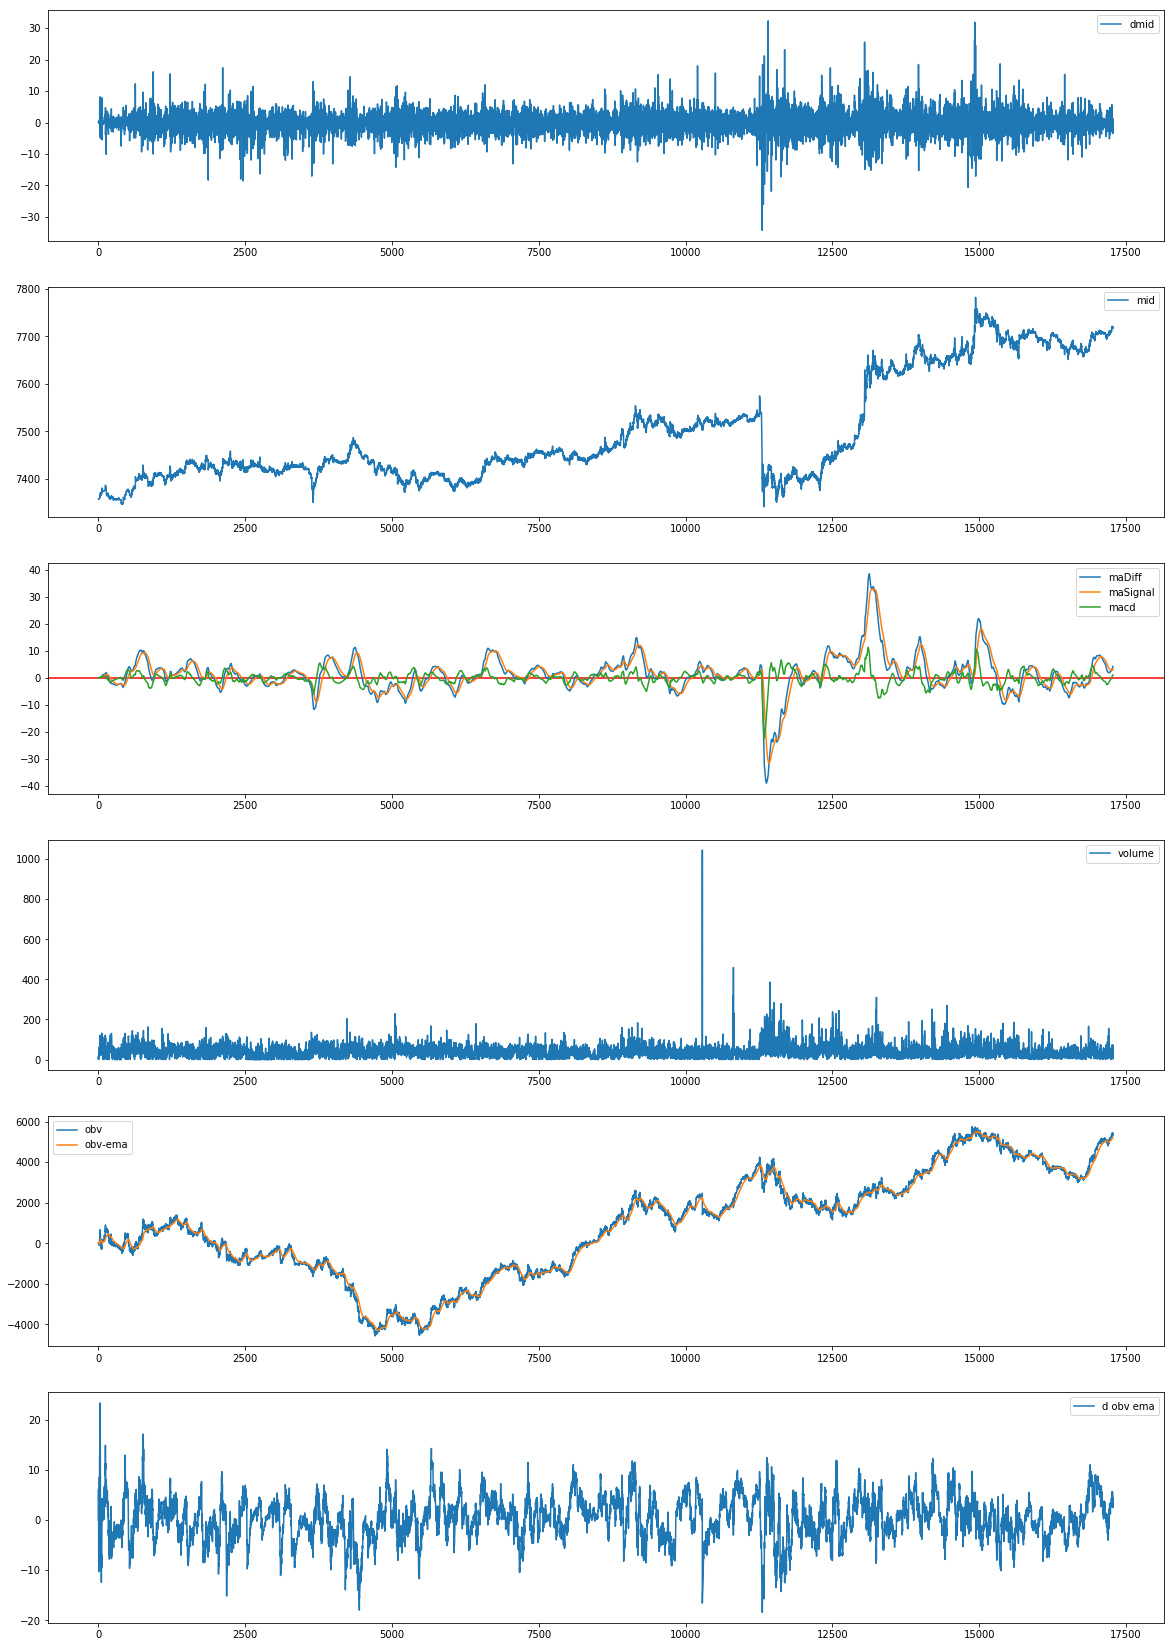

In [4]:
#data
df = pd.read_csv(rain.toRelPath("data/df-cache.csv"))
df = resampleData(df, FREQUENCY * 2)

mid = df["mid"]
volume = df["volume"]

dmid = mid - mid.shift(1)
macd, maDiff, maSignal, emaFast, emaSlow = rain.computeMACD(mid, 120, 260, 90)
obv = rain.computeOBV(mid, volume)
obvEMA = obv.ewm(span = 100).mean()
dOBVEVA = obvEMA - obvEMA.shift(1)

plt.figure(figsize = (20, 50))
plt.subplot(10, 1, 1)
plt.plot(dmid, label = "dmid")
plt.legend()
plt.subplot(10, 1, 2)
plt.plot(mid, label = "mid")
plt.legend()
plt.subplot(10, 1, 3)
plt.axhline(y = 0, color = "r")
plt.plot(maDiff, label = "maDiff")
plt.plot(maSignal, label = "maSignal")
plt.plot(macd, label = "macd")
plt.legend()
plt.subplot(10, 1, 4)
plt.plot(volume, label = "volume")
plt.legend()
plt.subplot(10, 1, 5)
plt.plot(obv, label = "obv")
plt.plot(obvEMA, label = "obv-ema")
plt.legend()
plt.subplot(10, 1, 6)
plt.plot(dOBVEVA, label = "d obv ema")
plt.legend()
plt.show()

In [5]:
#prep
train = [[], []]
for a in range(1, len(mid) - TIMESTEP_LEN):
    train[0].append([
        dmid[a:a + TIMESTEP_LEN].values,
        macd[a:a + TIMESTEP_LEN].values,
        mid[a:a + TIMESTEP_LEN].values,
        maDiff[a:a + TIMESTEP_LEN].values,
        volume[a:a + TIMESTEP_LEN].values
    ])
    train[0][-1] = np.reshape(train[0][-1], (TIMESTEP_LEN * FEATURES), order = "F")
    train[0][-1] = np.reshape(train[0][-1], (TIMESTEP_LEN, FEATURES))
    train[1].append(dmid[a + TIMESTEP_LEN])
print("Patters:", len(train[0]))
train[0] = np.array(train[0])
print(train[0].shape)

valCount = int(VALIDATION_RATIO * len(train[0]))
validation = [train[0][-valCount:], train[1][-valCount:]]
train = [train[0][:-valCount], train[1][:-valCount]]
print(len(train[0]), len(validation[0]))
print(train[0][0], train[1][0])

Patters: 17179
(17179, 100, 5)
14603 2576
[[ 2.75000000e-01  3.05065883e-04  7.35828000e+03  6.16987179e-04
   4.07841300e+00]
 [ 1.00000000e-02  3.54265730e-04  7.35829000e+03  8.49312776e-04
   1.27730000e-02]
 [ 2.50000000e-02  4.09756232e-04  7.35831500e+03  1.04757283e-03
   1.78647560e+01]
 [ 0.00000000e+00  4.16056833e-04  7.35831500e+03  1.16379605e-03
   7.43120000e+00]
 [-4.00000000e-02  2.79549529e-04  7.35827500e+03  1.08702369e-03
   3.30937600e+00]
 [-1.00000000e-02  1.56453359e-04  7.35826500e+03  9.92091938e-04
   4.08752070e+01]
 [-2.60000000e-01 -8.31032979e-04  7.35800500e+03 -1.25021821e-04
   3.78455110e+01]
 [ 2.65000000e-01 -5.32291195e-04  7.35827000e+03  1.00280810e-04
   9.15101900e+00]
 [ 0.00000000e+00 -3.14658791e-04  7.35827000e+03  2.78906481e-04
   2.27057090e+01]
 [ 0.00000000e+00 -1.52752935e-04  7.35827000e+03  4.23586203e-04
   2.53091220e+01]
 [-5.00000000e-03 -4.97672878e-05  7.35826500e+03  5.21414962e-04
   6.00265200e+00]
 [ 2.00000000e-02  1.08

In [6]:
#model
model = keras.models.Sequential()
#timesteps of history - with a vector of size 1 per timestep
model.add(keras.layers.GRU(64, input_shape = (TIMESTEP_LEN, FEATURES), return_sequences = True))
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.GRU(64))
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.add(keras.layers.Activation("linear"))
model.compile(loss = "mean_squared_logarithmic_error", 
    optimizer = keras.optimizers.adam(lr = 0.0003))

In [7]:
#fit
MODEL_NAME = input("Model name: ")

model.fit(
    train[0], 
    train[1], 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            rain.toRelPath("weights/" + MODEL_NAME + "_{epoch}_{val_loss:.4f}.h5"), 
            save_weights_only = True
        )
    ],
    validation_data = (
        validation[0], 
        validation[1]
    )
)

Model name: 14
Train on 14603 samples, validate on 2576 samples
Epoch 1/64
14603/14603 [==============================] - 21s 1ms/step - loss: 0.4028 - val_loss: 0.3723
Epoch 2/64
14603/14603 [==============================] - 16s 1ms/step - loss: 0.3702 - val_loss: 0.3678
Epoch 3/64
14603/14603 [==============================] - 14s 981us/step - loss: 0.3679 - val_loss: 0.3673
Epoch 4/64
14603/14603 [==============================] - 14s 935us/step - loss: 0.3672 - val_loss: 0.3677
Epoch 5/64
14603/14603 [==============================] - 15s 1ms/step - loss: 0.3662 - val_loss: 0.3677
Epoch 6/64
14603/14603 [==============================] - 15s 1ms/step - loss: 0.3659 - val_loss: 0.3680
Epoch 7/64
14603/14603 [==============================] - 14s 938us/step - loss: 0.3644 - val_loss: 0.3676
Epoch 8/64
14603/14603 [==============================] - 14s 935us/step - loss: 0.3636 - val_loss: 0.3679
Epoch 9/64
14603/14603 [==============================] - 14s 938us/step - loss: 0.3647 

KeyboardInterrupt: 